In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

In [2]:
# Load data 
data = pd.read_csv('diabetes-2-1.csv')

# Check the shape of data set and missibg values
print('Missing values: ',data.isnull().sum().sum())
data

Missing values:  0


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


## EDA

In [3]:
# Customized colors for the plots
blues_cmap = plt.get_cmap('Blues')

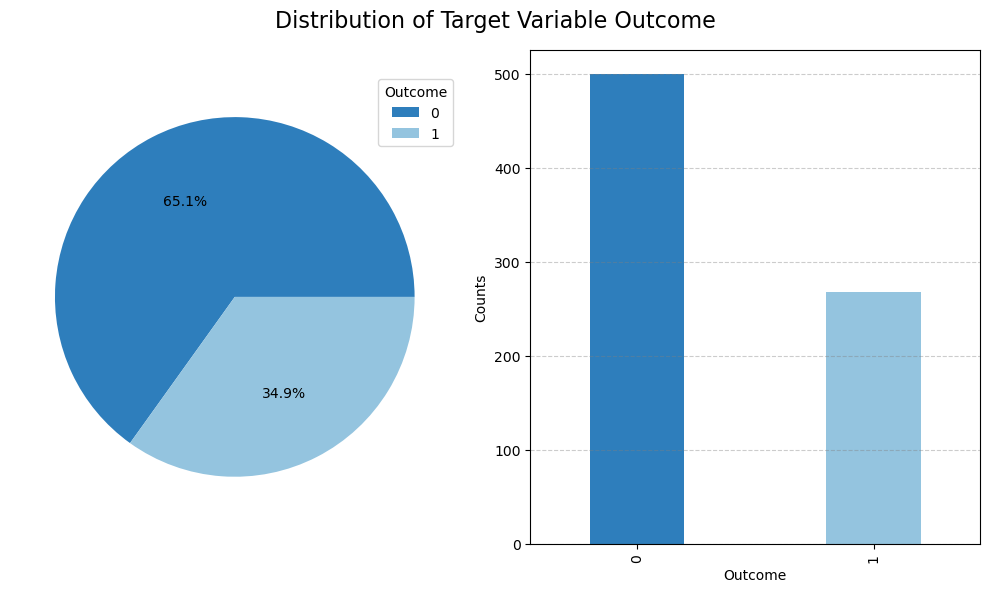

In [4]:
# Distribution of target (Outcome)

fig, ax = plt.subplots(1, 2, figsize=(10,6))

# Create Series for distribution of Outcome
proportion = data.Outcome.value_counts(normalize=True)
value_counts = data.Outcome.value_counts()

# Pie chart for Outcome
ax[0].pie(proportion, autopct='%1.1f%%', colors=[blues_cmap(0.7), blues_cmap(0.4)])
ax[0].legend(proportion.index, title='Outcome')

# Bar chart for Outcome
value_counts.plot(kind='bar',color=[blues_cmap(0.7), blues_cmap(0.4)], ax=ax[1], width=0.4)
ax[1].set_ylabel('Counts')
ax[1].grid(axis='y', color='grey', linestyle='--', alpha=0.4)

plt.suptitle('Distribution of Target Variable Outcome', fontsize=16)
plt.tight_layout()

We have small dataset with imbalanced classes (with ratio 65 to 35), this should be taken into consideration during modeling.  

       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
25%       1.000000   99.000000      62.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    31.992578                  0.471876   33.240885    0.348958  
std      7.884160                  0.331329   11.760232    0.476951  
min      0.000000                  

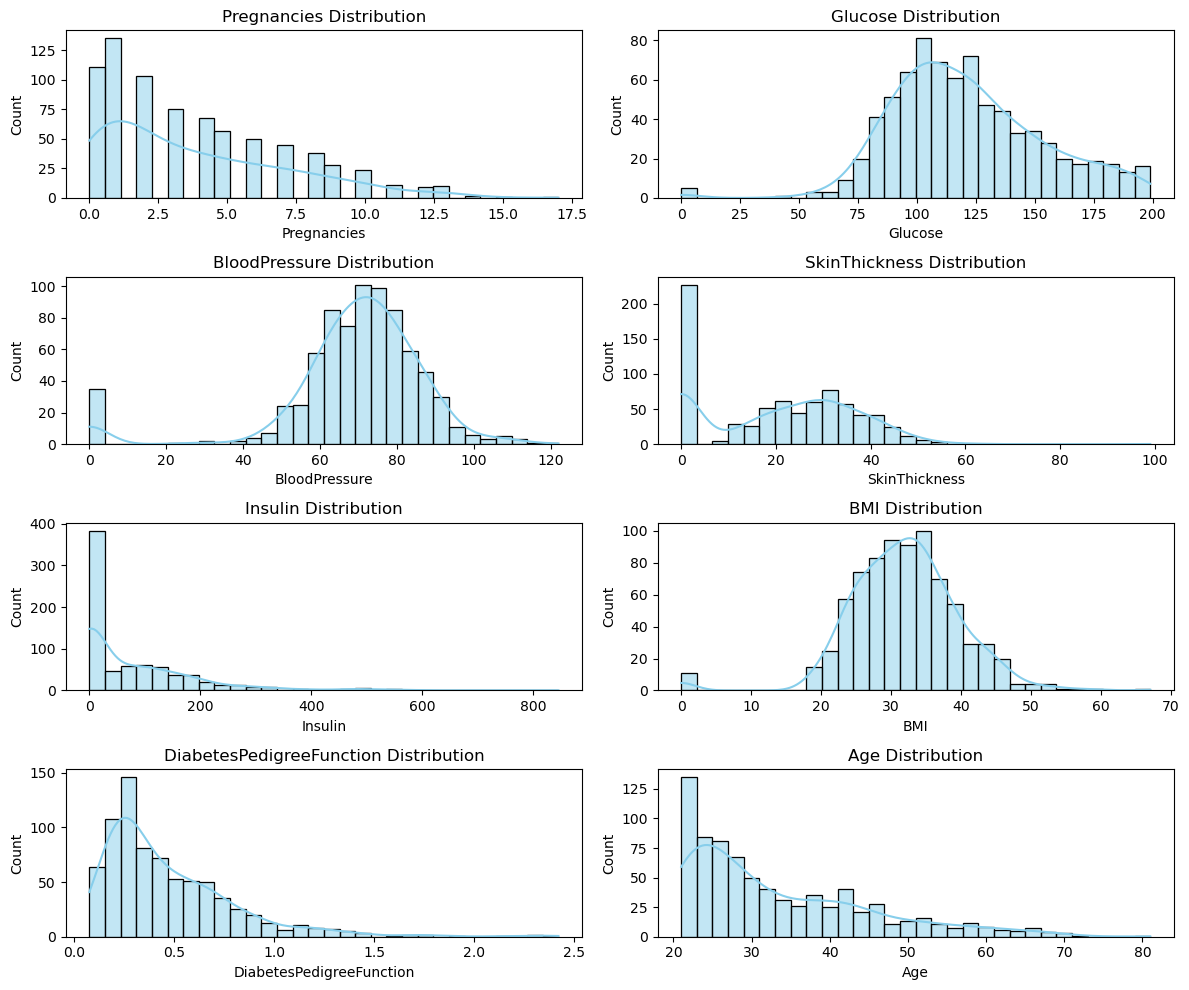

In [5]:
# Select list of features
features = data.drop(columns='Outcome').columns.tolist()

# Statistics
print(data.describe())

# Distribution of features
num_subplots = len(features) // 2 + len(features) % 2

fig, ax = plt.subplots(num_subplots,2,figsize=(12,10))

for i, col in enumerate(features):
    # Get subplot position
    row, col_idx = divmod(i,2)
    # Histogram
    sns.histplot(data[col], bins=30, kde=True, ax=ax[row, col_idx], color='skyblue')

    # Title and labels
    ax[row, col_idx].set(title=f'{col} Distribution',
                         xlabel=col,
                         ylabel='Count')   
plt.tight_layout()

Biologically not plausible values (equal to zero) for Glucose, Blood Pressure, BMI, Skin Thickness, and Insulin are present in this dataset. These values should be addressed and dealt as missing values.

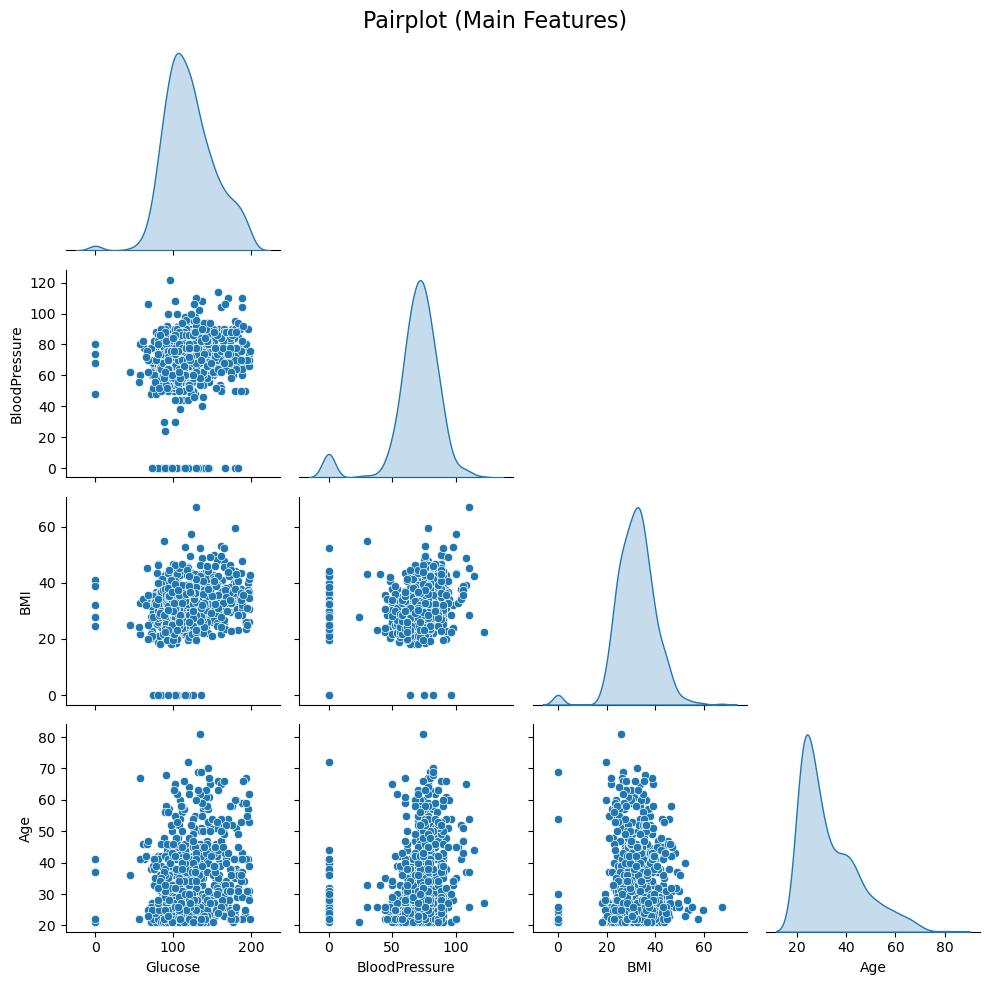

In [6]:
# Choose main predictors for pairplot
cols_plot = ['Glucose', 'BloodPressure', 'BMI', 'Age']

# Pairplot
sns.pairplot(
    data[cols_plot],
    corner=True,
    diag_kind='kde'
)
plt.suptitle('Pairplot (Main Features)', fontsize=16)

plt.tight_layout()

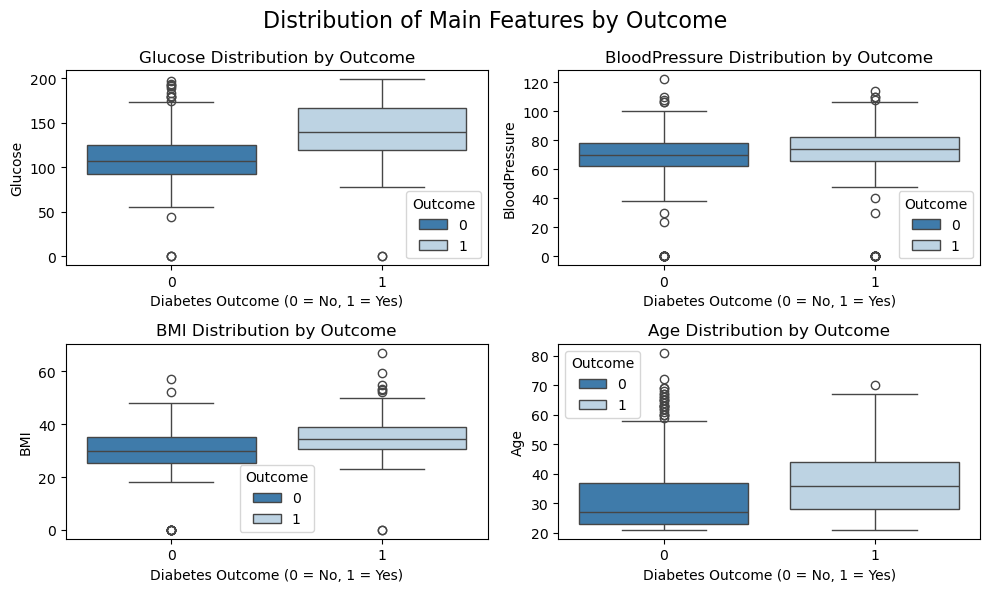

In [221]:
# Box plots for main predictors by Outcome
num_subplots = len(cols_plot) // 2 + len(cols_plot) % 2

fig, ax = plt.subplots(num_subplots,2,figsize=(10,6))

for i, col in enumerate(cols_plot):
    # Get subplot position
    row, col_idx = divmod(i, 2)
    # Box plot
    sns.boxplot(x='Outcome',
                y=col,
                data=data,
                palette=[blues_cmap(0.7), blues_cmap(0.3)],
                hue='Outcome',
                ax=ax[row, col_idx])

    # Title and labels for each subplot
    ax[row,col_idx].set(title=f'{col} Distribution by Outcome',
                        xlabel='Diabetes Outcome (0 = No, 1 = Yes)')
    
plt.suptitle('Distribution of Main Features by Outcome', fontsize=16)
plt.tight_layout()

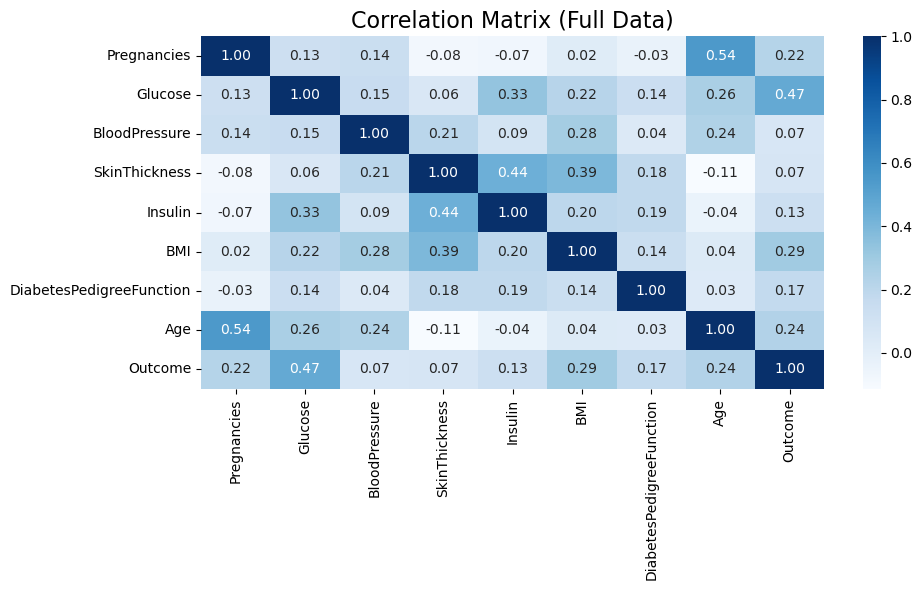

In [7]:
# Correlation matrix
fig, ax = plt.subplots(figsize=(10,6))

sns.heatmap(data.corr(), annot=True, cmap=blues_cmap, fmt='.2f', ax=ax)
ax.set_title('Correlation Matrix (Full Data)', fontsize=16)

plt.tight_layout()

# Preprocessing

### Missing values

Percentage of missing values (%):

Pregnancies                  0.00
Glucose                      0.65
BloodPressure                4.56
SkinThickness               29.56
Insulin                     48.70
BMI                          1.43
DiabetesPedigreeFunction     0.00
Age                          0.00
Outcome                      0.00
Insulin_missing              0.00
SkinThickness_missing        0.00
dtype: float64


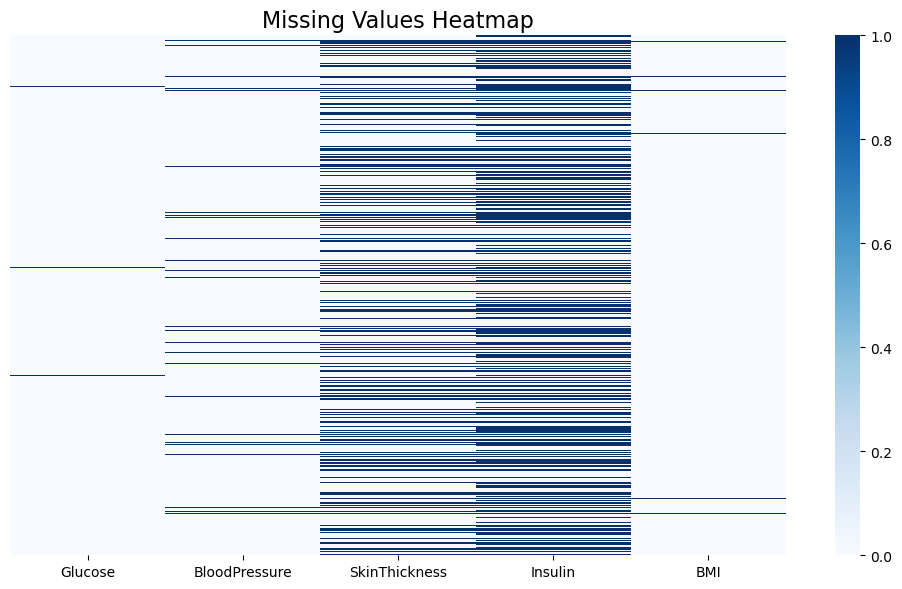

In [8]:
# Define columns which require the replacement of bilogically unpleasant values (zeros) with nan
missing_cols = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

for col in missing_cols:
    # Replace 0 entries for Glucose, BloodPressure, SkinThickness, Insulin, BMI with NaN
    data[col] = data[col].replace({0: np.nan})
    
# Create an indicator of missing values for Insulin and SkinThickness columns
data['Insulin_missing'] = data.Insulin.isnull().astype(int)
data['SkinThickness_missing'] = data.SkinThickness.isnull().astype(int)

# Missing values after replacement
print('Percentage of missing values (%):\n')
print(np.round(data.isnull().mean() * 100, 2))

# Check the distribution of missing values
fig, ax = plt.subplots(figsize=(10,6))

sns.heatmap(data[missing_cols].isnull(), annot=False, cmap=blues_cmap, yticklabels=False, ax=ax)

ax.set_title('Missing Values Heatmap', fontsize=16)

plt.tight_layout()

Since SkinThickness and Insulin have very large amount of missing values ( around 30% and 50% respectively). The imputation is not reliable, the best solution is to drop these variables and leave missing values indicators instead.

### Feature Engineering

In [9]:
# Create additional categorical variables
data['Glucose_Category'] = pd.cut(data.Glucose, bins=[0, 100, 125, 300], labels=['normal', 'prediabetic', 'diabetic'])
data['BMI_Category'] = pd.cut(data.BMI, bins=[0, 18.5, 25, 30, 100], labels=['underweight', 'normal', 'overweight', 'obese'])

# Modeling

In [10]:
# Import necessary libraries
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report, confusion_matrix
from sklearn.metrics import precision_score
import shap

In [11]:
#!pip install prettytable

# Table for model comparison
from prettytable import PrettyTable

# Create a table instance
table = PrettyTable()

# Create headers
table.field_names = ['Model', 'ROC-AUC', 'PR-AUC', 'Precision (Weighted)',
                     'Recall (Weighted)', 'F1-Score (Weighted)', 'Specificity', 'Accuracy', 'Features']
print(table)

+-------+---------+--------+----------------------+-------------------+---------------------+-------------+----------+----------+
| Model | ROC-AUC | PR-AUC | Precision (Weighted) | Recall (Weighted) | F1-Score (Weighted) | Specificity | Accuracy | Features |
+-------+---------+--------+----------------------+-------------------+---------------------+-------------+----------+----------+
+-------+---------+--------+----------------------+-------------------+---------------------+-------------+----------+----------+


In [12]:
# Function for evaluating models
def evaluate_model(model, model_name, X_test, y_test, feature_names, table):
    '''
    Evaluates model, adds results to the comparison table and returns all key metrics.
    
    Parameters:
    - model: Trained classifier model
    - model_name: Name of the model for titles
    - X_test: Processed test data
    - y_test: Actual test labels
    - feature_names: List of feature names
    - table: Table to store metrics for the model
    
    '''
    
    y_pred = model.predict(X_test)
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    # Calculate TN, FP, FN, TP
    tn, fp, fn, tp = cm.ravel()
    
    # Calculate specificity
    specificity = tn / (tn + fp)

    # Get probabilities for class 1
    y_prob = model.predict_proba(X_test)[:, 1]

    # Classification report
    report = classification_report(y_test, y_pred, output_dict=True)

    # Calculate ROC-AUC
    roc_auc = roc_auc_score(y_test, y_prob)

    # Calculate PR-AUC
    pr_auc = average_precision_score(y_test, y_prob)

    # Add results to the table
    table.add_row([
        model_name,
        np.round(roc_auc, 2),
        np.round(pr_auc, 2),
        np.round(report['weighted avg']['precision'], 2),
        np.round(report['weighted avg']['recall'], 2),
        np.round(report['weighted avg']['f1-score'], 2),
        np.round(specificity, 2),
        np.round(report['accuracy'], 2),
        len(feature_names)
    ])

    return {
        'ROC-AUC': roc_auc,
        'PR-AUC': pr_auc,
        'Precision (Weighted)': report['weighted avg']['precision'],
        'Recall (Weighted)': report['weighted avg']['recall'],
        'F1-Score (Weighted)': report['weighted avg']['f1-score'],
        'Specificity': specificity,
        'Accuracy': report['accuracy']
    }
    

# Function for visualization SHAP feature importance and confusion matrix
def plot_model_explanations(model, model_name, X_train, X_test, y_test, feature_names, color, cmap):
    '''
    Plot SHAP feature importance and confusion matrix for each model

    Parameters:
    - model: Trained classifier model
    - model_name: Name of the model for titles
    - X_train: Processed train data
    - X_test: Processed test data
    - y_test: Actual test labels
    - feature_names: List of feature names
    - color: Color for summary plot
    - cmap: Colormap for confusion matrix
    
    '''
    # Compute SHAP values
    if model_name == 'SVM':
        explainer = shap.KernelExplainer(model.predict_proba, X_train)
    else:
        explainer = shap.Explainer(model, X_train)
    shap_values = explainer(X_test, check_additivity=False) if (model_name == 'Random Forest') | (model_name == 'LightGBM') else explainer(X_test)

    # Scale for Random Forest
    if (model_name == 'Random Forest') | (model_name == 'SVM'):
        shap_values = shap_values[:, :, 1]

    # Plot SHAP summary(feature importance)
    plt.figure(figsize=(6,5))
    shap.summary_plot(shap_values, X_test, feature_names=feature_names, plot_type='bar', show=False)

    # Customize color
    for bar in plt.gca().patches:
        bar.set_color(color)

    plt.title(f'Feature Importance (SHAP values) - {model_name}')
    plt.xlabel('')
    plt.show()

    # Compute and visualize confusion matrix
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    fig, ax = plt.subplots(figsize=(6,5))

    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, ax=ax,
                xticklabels=['Predicted No', 'Predicted Yes'],
                yticklabels=['Actual No', 'Actual Yes'])

    ax.set(title=f'Confusion Matrix - {model_name}',
           xlabel='Predicted',
           ylabel='Actual')
    plt.show()

    plt.tight_layout(pad=3.0)
    

In [13]:
# Select features and target
X = data.drop(columns=['Outcome', 'Insulin', 'SkinThickness'])
y = data.Outcome

# Split into Train (60%), Validation (20%) and Test (20%) sets to be used by all models
# Stratify on the target Outcome to handle dataset imbalance
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=0)
# 0.2 / 0.8 = 0.25
X_train, X_val, y_train, y_val =train_test_split(X_train_val, y_train_val, stratify=y_train_val, random_state=0)

# Select numerical and categorical columns
num_cols = X.select_dtypes(include='number').columns 
# Remove Insulin_missing and SkinThickness_missing from numerical columns since no need for preprocessing
num_cols = list(set(num_cols) - set(['Insulin_missing', 'SkinThickness_missing']))
cat_cols = X.select_dtypes(include='category').columns

# Define numerical transformer
num_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# Define categorical transformer
cat_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))])

# Combined preprocessor
preprocessor = ColumnTransformer([
    ('num', num_transformer, num_cols),
    ('cat', cat_transformer, cat_cols)],
                                 remainder='passthrough')

# Fit preprocessor on training data
preprocessor.fit(X_train)

# Get feature names out after preprocessing and and align them across transformed train, validation and test sets
feature_names = preprocessor.get_feature_names_out()
feature_names_cleaned = [name.split('__')[-1] for name in feature_names]

# Transform all sets using the fitted preprocessor
X_train_processed = pd.DataFrame(preprocessor.transform(X_train), index=X_train.index, columns=feature_names)
X_val_processed = pd.DataFrame(preprocessor.transform(X_val), index=X_val.index, columns=feature_names)
X_test_processed = pd.DataFrame(preprocessor.transform(X_test), index=X_test.index, columns=feature_names)
X_train_val_processed = pd.DataFrame(preprocessor.transform(X_train_val), index=X_train_val.index, columns=feature_names)

## 1. Logistic Regression

### 1.a Full features

              precision    recall  f1-score   support

           0       0.84      0.79      0.81       100
           1       0.65      0.72      0.68        54

    accuracy                           0.77       154
   macro avg       0.75      0.76      0.75       154
weighted avg       0.77      0.77      0.77       154

Confusion Matrix:
 [[79 21]
 [15 39]]


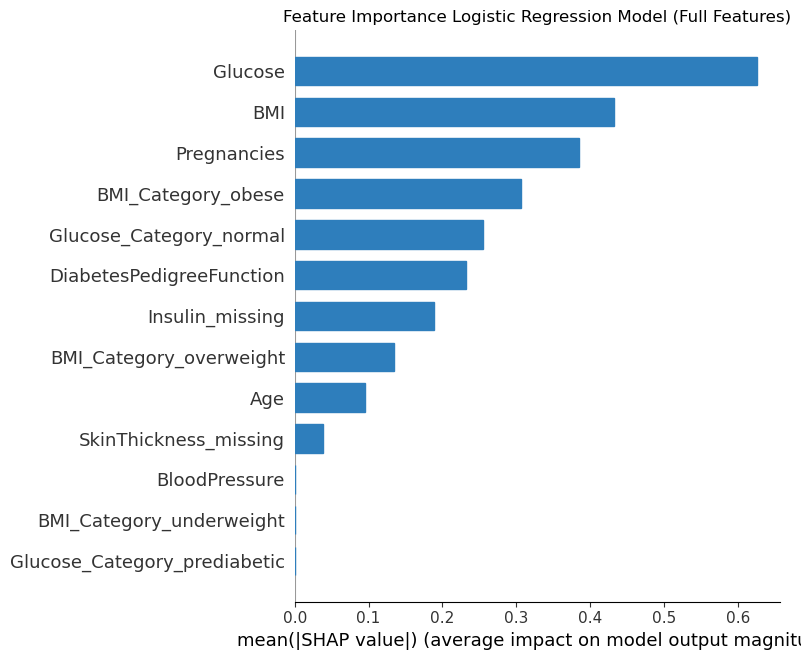

In [14]:
# Import LogisticRegression
from sklearn.linear_model import LogisticRegression

# Initialize Logistic Regression model with handling class-weight imbalance and fit on processed train set
model = LogisticRegression(class_weight='balanced', solver='liblinear', penalty='l1').fit(X_train_processed, y_train)

# Predict
y_pred = model.predict(X_val_processed)

# Calculate classification report and confusion matrix
print(classification_report(y_val, y_pred))
print('Confusion Matrix:\n', confusion_matrix(y_val, y_pred))

# Check feature importance according to their SHAP values
# Explainer for Logistic Regression
explainer = shap.Explainer(model, X_train_processed)
# Get SHAP values for the validation set
shap_values = explainer(X_val_processed)

# Visualize SHAP values for feature importance
plt.figure(figsize=(6,5))
shap.summary_plot(shap_values,
                  X_val_processed,
                  feature_names=feature_names_cleaned,
                  plot_type='bar',
                  show=False)
# Custom color for bars
for bar in plt.gca().patches:
    bar.set_color(blues_cmap(0.7))

plt.title('Feature Importance Logistic Regression Model (Full Features)')

plt.tight_layout()

### 1.b Selected features (according to their importance for the model)

Select top 4 features 

Parameters: {'C': 1}, Cross-validated PR-AUC: 0.7051652549039168
{'ROC-AUC': 0.8775925925925926, 'PR-AUC': 0.8108072375161692, 'Precision (Weighted)': 0.7942635541789428, 'Recall (Weighted)': 0.7857142857142857, 'F1-Score (Weighted)': 0.7883500144820261, 'Specificity': 0.8, 'Accuracy': 0.7857142857142857}


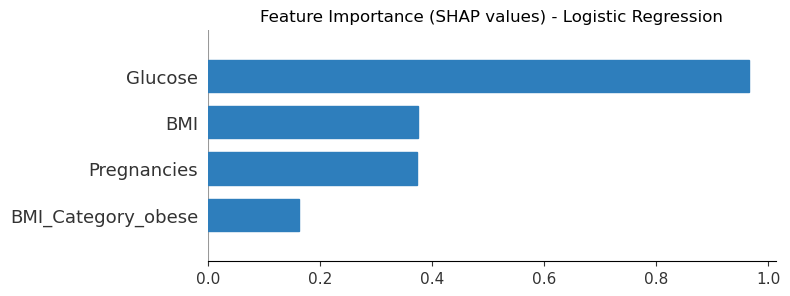

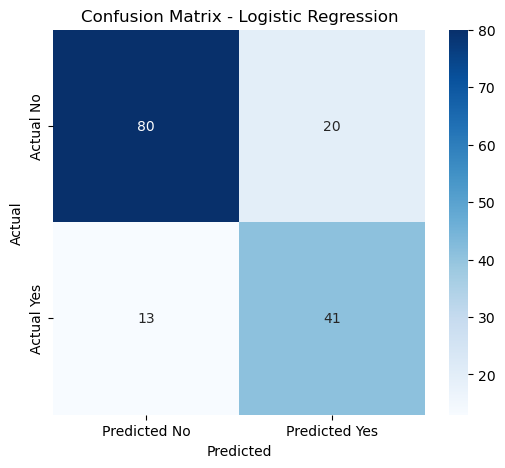

<Figure size 640x480 with 0 Axes>

In [15]:
# Get top 4 features indices frpm SHAP
top_features_idx = np.argsort(np.abs(shap_values.values).mean(axis=0))[-4:]

# Select top 8 features for train, validation and test sets
X_train_reduced = X_train_processed.iloc[:, top_features_idx]
X_val_reduced = X_val_processed.iloc[:, top_features_idx]
X_test_reduced = X_test_processed.iloc[:, top_features_idx]
X_train_val_reduced = X_train_val_processed.iloc[:, top_features_idx]

# Get cleaned top features
top_features = [col.split('__')[-1] for col in X_train_reduced.columns]

# Define the parameter grid
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],    # Regularization strength
}

# Use GridSearchCV
search = GridSearchCV(LogisticRegression(class_weight='balanced', solver='liblinear', penalty='l1', random_state=0),
                      param_grid,
                      cv=5,
                      scoring='average_precision',
                      n_jobs=-1)
search.fit(X_train_reduced, y_train)

# Best model
log_reg = search.best_estimator_

# Fit on combined train and validation sets
log_reg.fit(X_train_val_reduced, y_train_val)

# Best params
print(f'Parameters: {search.best_params_}, Cross-validated PR-AUC: {search.best_score_}')

# Calculate probabilities for the comparison plots
y_prob_log_reg = log_reg.predict_proba(X_test_reduced)[:, 1]

# Evaluate model 
results = evaluate_model(log_reg, 'Logistic Regression', X_test_reduced, y_test, top_features, table)
print(results)

# Visualize SHAP feature importance and confusion matrix
plot_model_explanations(log_reg, 'Logistic Regression', X_train_val_reduced, X_test_reduced, y_test,
                        top_features, blues_cmap(0.7),'Blues')

## 2. XGBoost

### 2.a Full features

              precision    recall  f1-score   support

           0       0.84      0.81      0.83       100
           1       0.67      0.72      0.70        54

    accuracy                           0.78       154
   macro avg       0.76      0.77      0.76       154
weighted avg       0.78      0.78      0.78       154

Confusion Matrix:
 [[81 19]
 [15 39]]


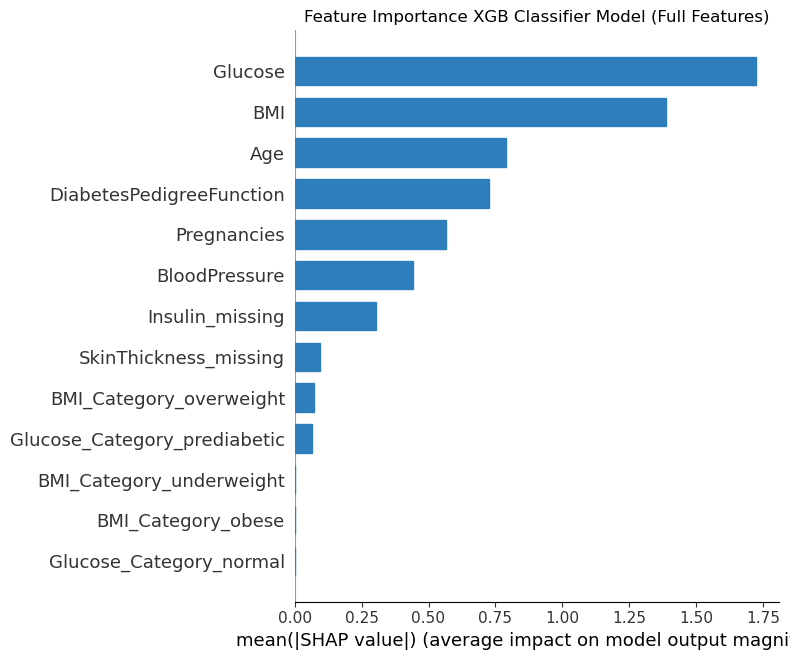

In [16]:
from xgboost import XGBClassifier

# Initialize XGBoost model with handling class-weight imbalance and fit on processed train set
model = XGBClassifier(scale_pos_weight=1.87).fit(X_train_processed, y_train)  # 65.1 / 34.9 = 1.87

# Predict
y_pred = model.predict(X_val_processed)

# Calculate classification report and confusion matrix
print(classification_report(y_val, y_pred))
print('Confusion Matrix:\n', confusion_matrix(y_val, y_pred))

# Check feature importance according to their SHAP values
# Explainer for XGBoost model
explainer = shap.Explainer(model, X_train_processed)
# Get SHAP values for the validation set
shap_values = explainer(X_val_processed)

# Visualize SHAP values for feature importance
plt.figure(figsize=(6,5))
shap.summary_plot(shap_values,
                  X_val_processed,
                  feature_names=feature_names_cleaned,
                  plot_type='bar',
                  show=False)
# Custom color for bars
for bar in plt.gca().patches:
    bar.set_color(blues_cmap(0.7))

plt.title('Feature Importance XGB Classifier Model (Full Features)')

plt.tight_layout()

### 2.b Selected features (according to their importance for the model)

Select top 4 features

Parameters: {'colsample_bytree': 0.8, 'early_stopping_rounds': 20, 'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 200, 'reg_alpha': 1.0, 'reg_lambda': 0.1, 'scale_pos_weight': 1.8, 'subsample': 0.8}, Cross-validated PR-AUC: 0.6918468003022307
{'ROC-AUC': 0.8562962962962962, 'PR-AUC': 0.7894687043789724, 'Precision (Weighted)': 0.7913852427679368, 'Recall (Weighted)': 0.7857142857142857, 'F1-Score (Weighted)': 0.7877078673538851, 'Specificity': 0.81, 'Accuracy': 0.7857142857142857}


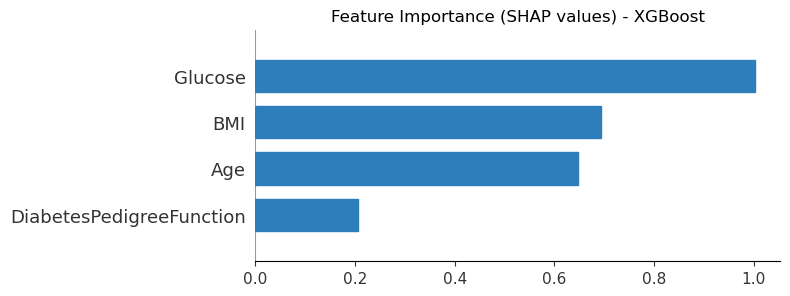

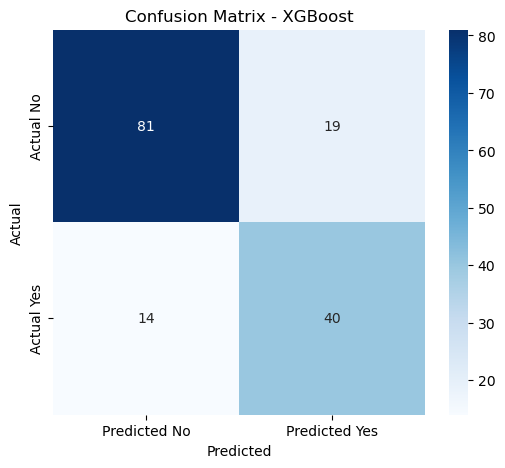

<Figure size 640x480 with 0 Axes>

In [17]:
# Get top 4 features indices frpm SHAP
top_features_idx = np.argsort(np.abs(shap_values.values).mean(axis=0))[-4:]

# Select top 8 features for train, validation and test sets
X_train_reduced = X_train_processed.iloc[:, top_features_idx]
X_val_reduced = X_val_processed.iloc[:, top_features_idx]
X_test_reduced = X_test_processed.iloc[:, top_features_idx]
X_train_val_reduced = X_train_val_processed.iloc[:, top_features_idx]

# Get cleaned top features
top_features = [col.split('__')[-1] for col in X_train_reduced.columns]

# Define the parameter grid
param_grid = {
    'learning_rate': [0.01, 0.05],        # Lower to prevent overfitting
    'max_depth': [2, 3],                  # Shallow trees
    'n_estimators': [200],                # Use with early stopping
    'subsample': [0.8],                   # Stochastic boosting
    'colsample_bytree': [0.8],            # Random subspace
    'reg_alpha': [1.0],                   # L1 regularization
    'reg_lambda': [0.05, 0.1, 1.0],       # L2 regularization
    'scale_pos_weight': [1.8, 1.87, 2.0], # To handle class imbalance (approx 65/35 imbalance ratio)
    'early_stopping_rounds': [20] 
}

# Use GridSearchCV
search = GridSearchCV(XGBClassifier(eval_metric='logloss', random_state=0),
                      param_grid,
                      cv=5,
                      scoring='average_precision',
                      n_jobs=-1)
search.fit(X_train_reduced, y_train, eval_set=[(X_val_reduced, y_val)], verbose=False)

# Best model
xgb_classifier = search.best_estimator_

# Best params
print(f'Parameters: {search.best_params_}, Cross-validated PR-AUC: {search.best_score_}')

# Calculate probabilities
y_prob_xgb = xgb_classifier.predict_proba(X_test_reduced)[:, 1]

# Evaluate model 
results = evaluate_model(xgb_classifier, 'XGBoost', X_test_reduced, y_test, top_features, table)
print(results)

# Visualize SHAP feature importance and confusion matrix
plot_model_explanations(xgb_classifier, 'XGBoost', X_train_val_reduced, X_test_reduced, y_test,
                        top_features, blues_cmap(0.7),'Blues')


## 3. Random Forest

### 3.a Full features

              precision    recall  f1-score   support

           0       0.81      0.88      0.84       100
           1       0.73      0.61      0.67        54

    accuracy                           0.79       154
   macro avg       0.77      0.75      0.75       154
weighted avg       0.78      0.79      0.78       154

Confusion Matrix:
 [[88 12]
 [21 33]]


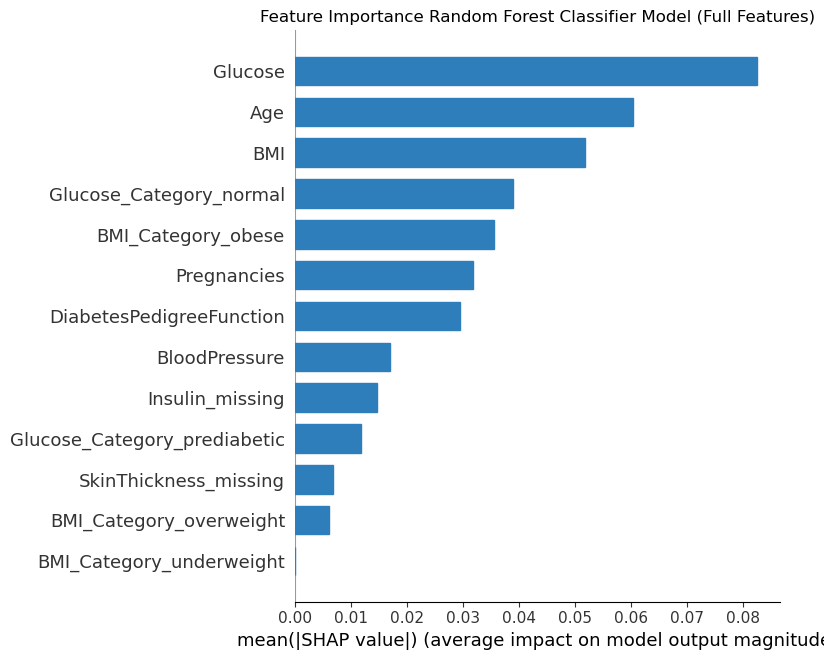

In [18]:
from sklearn.ensemble import RandomForestClassifier

# Initialize Random Forest model with handling class-weight imbalance and fit on processed train set
model = RandomForestClassifier(class_weight='balanced').fit(X_train_processed, y_train)  

# Predict
y_pred = model.predict(X_val_processed)

# Calculate classification report and confusion matrix
print(classification_report(y_val, y_pred))
print('Confusion Matrix:\n', confusion_matrix(y_val, y_pred))

# Check feature importance according to their SHAP values
# Explainer for Random Forest model
explainer = shap.Explainer(model, X_train_processed)
# Get SHAP values for the validation set
shap_values = explainer(X_val_processed, check_additivity=False)
shap_values = shap_values[:, :, 1]

# Visualize SHAP values for feature importance
plt.figure(figsize=(6,5))
shap.summary_plot(shap_values,
                  X_val_processed,
                  feature_names=feature_names_cleaned,
                  plot_type='bar',
                  show=False)
# Custom color for bars
for bar in plt.gca().patches:
    bar.set_color(blues_cmap(0.7))

plt.title('Feature Importance Random Forest Classifier Model (Full Features)')

plt.tight_layout()

### 3.b Selected features (according to their importance for the model)

Remove features with minimal importance to reduce noise 

Parameters: {'class_weight': 'balanced', 'max_depth': 5, 'min_samples_leaf': 20, 'n_estimators': 100}, Cross-validated PR-AUC: 0.6905872253106529
{'ROC-AUC': 0.8446296296296296, 'PR-AUC': 0.7683536876331549, 'Precision (Weighted)': 0.7864050842774247, 'Recall (Weighted)': 0.7792207792207793, 'F1-Score (Weighted)': 0.7816166470534348, 'Specificity': 0.8, 'Accuracy': 0.7792207792207793}


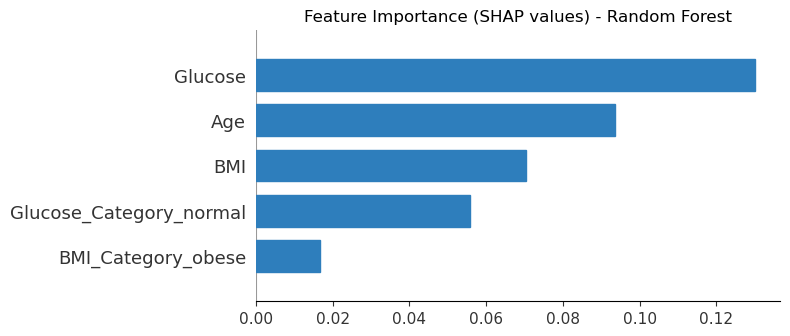

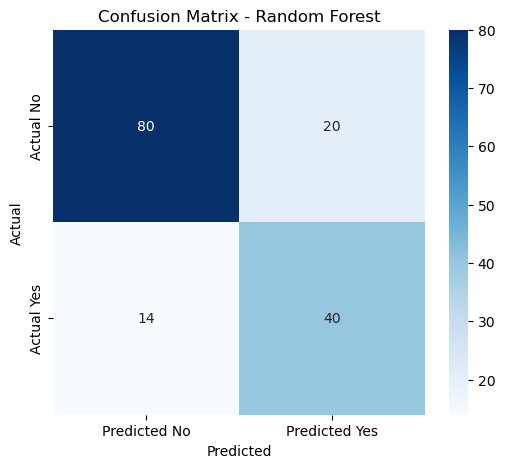

<Figure size 640x480 with 0 Axes>

In [19]:
# Get top 5 features indices frpm SHAP
top_features_idx = np.argsort(np.abs(shap_values.values).mean(axis=0))[-5:]

# Select top 8 features for train, validation and test sets
X_train_reduced = X_train_processed.iloc[:, top_features_idx]
X_val_reduced = X_val_processed.iloc[:, top_features_idx]
X_test_reduced = X_test_processed.iloc[:, top_features_idx]
X_train_val_reduced = X_train_val_processed.iloc[:, top_features_idx]

# Get cleaned top features
top_features = [col.split('__')[-1] for col in X_train_reduced.columns]

# Define the parameter grid
param_grid = {
    'max_depth': [3, 5],            # Prevent overfitting
    'n_estimators': [100, 200],     # Number of tres
    'class_weight': ['balanced'],   # For class imbalance
    'min_samples_leaf': [10, 20]    # Reduce leaf size
}

# Use GridSearchCV
search = GridSearchCV(RandomForestClassifier(random_state=0),
                      param_grid,
                      cv=5,
                      scoring='average_precision',
                      n_jobs=-1)
search.fit(X_train_reduced, y_train)

# Best model
rf_classifier = search.best_estimator_

# Fit on combined train and validation sets
rf_classifier.fit(X_train_val_reduced, y_train_val)

# Best params
print(f'Parameters: {search.best_params_}, Cross-validated PR-AUC: {search.best_score_}')

# Calculate probabilities
y_prob_rf = rf_classifier.predict_proba(X_test_reduced)[:, 1]

# Evaluate model 
results = evaluate_model(rf_classifier, 'Random Forest', X_test_reduced, y_test, top_features, table)
print(results)

# Visualize SHAP feature importance and confusion matrix
plot_model_explanations(rf_classifier, 'Random Forest', X_train_val_reduced, X_test_reduced, y_test,
                        top_features, blues_cmap(0.7),'Blues')

## 4. SVM

### 4.a Full features

              precision    recall  f1-score   support

           0       0.83      0.78      0.80       100
           1       0.63      0.70      0.67        54

    accuracy                           0.75       154
   macro avg       0.73      0.74      0.74       154
weighted avg       0.76      0.75      0.76       154

Confusion Matrix:
 [[78 22]
 [16 38]]


  0%|          | 0/154 [00:00<?, ?it/s]

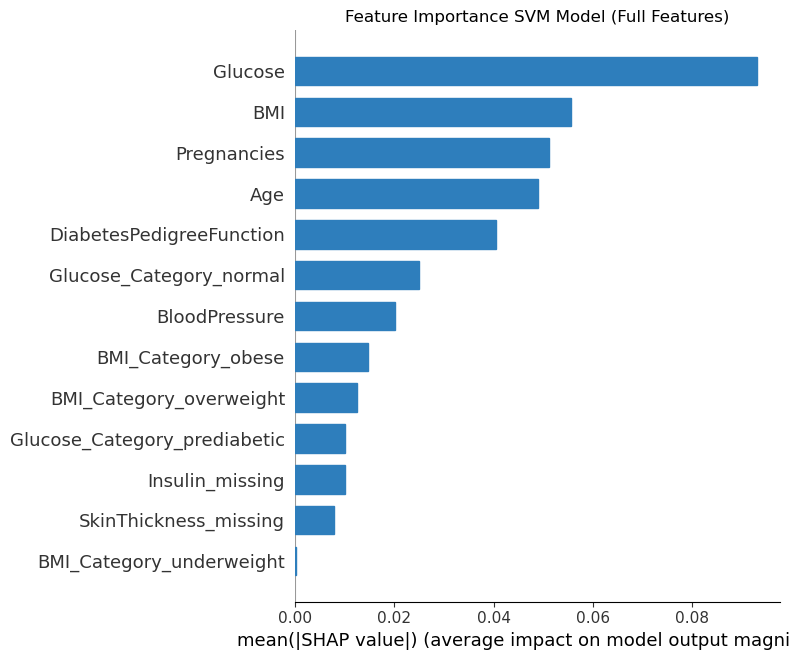

In [20]:
from sklearn.svm import SVC

# Initialize SVM model with handling class-weight imbalance and fit on processed train set
# Use hyperparameter 'probability=True' for SVC model to be able to use Explainer for the model
model = SVC(class_weight='balanced', probability=True).fit(X_train_processed, y_train)

# Predict
y_pred = model.predict(X_val_processed)

# Calculate classification report and confusion matrix
print(classification_report(y_val, y_pred))
print('Confusion Matrix:\n', confusion_matrix(y_val, y_pred))

# Check feature importance according to their SHAP values
# Use larger sample for SHAP (20% of data)
X_sample = X_train_processed.sample(frac=0.2, random_state=0)

# Explainer for SVM model
explainer = shap.KernelExplainer(model.predict_proba, X_sample)
# Get SHAP values for the validation set
shap_values = explainer.shap_values(X_val_processed)

# Visualize SHAP values for feature importance
plt.figure(figsize=(6,5))
shap.summary_plot(shap_values[:, :, 1],
                  X_val_processed,
                  feature_names=feature_names_cleaned,
                  plot_type='bar',
                  show=False)
# Custom color for bars
for bar in plt.gca().patches:
    bar.set_color(blues_cmap(0.7))

plt.title('Feature Importance SVM Model (Full Features)')

plt.tight_layout()

### 4.b Selected features (according to their importance for the model)

Select top 5 features

Parameters: {'C': 0.1, 'class_weight': 'balanced', 'gamma': 0.1, 'kernel': 'rbf'}, Cross-validated PR-AUC: 0.7208698853100659
{'ROC-AUC': 0.8674074074074073, 'PR-AUC': 0.77642352235195, 'Precision (Weighted)': 0.7880283191500701, 'Recall (Weighted)': 0.7662337662337663, 'F1-Score (Weighted)': 0.7708489289663272, 'Specificity': 0.75, 'Accuracy': 0.7662337662337663}


  0%|          | 0/154 [00:00<?, ?it/s]

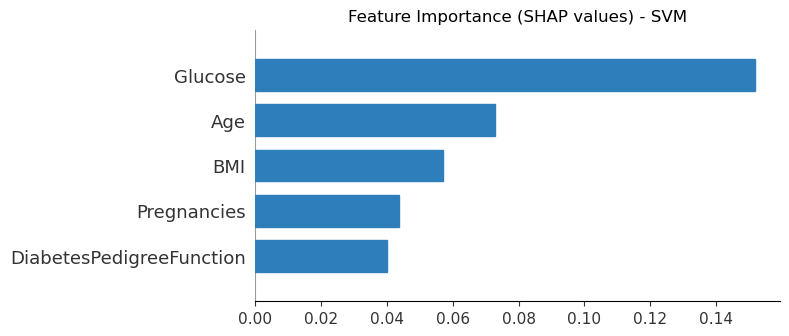

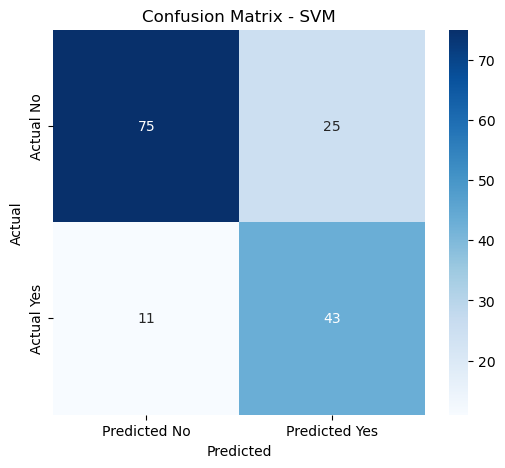

<Figure size 640x480 with 0 Axes>

In [21]:
# Get top 5 features indices frpm SHAP
top_features_idx = np.argsort(np.abs(shap_values[:, :, 1]).mean(axis=0))[-5:]

# Select top 8 features for train, validation and test sets
X_train_reduced = X_train_processed.iloc[:, top_features_idx]
X_val_reduced = X_val_processed.iloc[:, top_features_idx]
X_test_reduced = X_test_processed.iloc[:, top_features_idx]
X_train_val_reduced = X_train_val_processed.iloc[:, top_features_idx]

# Get cleaned top features
top_features = [col.split('__')[-1] for col in X_train_reduced.columns]

# Define the parameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10],               # Regularization strength
    'kernel': ['linear', 'rbf', 'poly'],   # Linear for simplicity, RBF for non-linear
    'gamma': ['scale', 'auto', 0.1, 1],    # For rbf/poly kernels
    'class_weight': ['balanced']
}

# Use GridSearchCV
search = GridSearchCV(SVC(probability=True, random_state=0),
                      param_grid,
                      cv=5,
                      scoring='average_precision',
                      n_jobs=-1)
search.fit(X_train_reduced, y_train)

# Best model
svm_classifier = search.best_estimator_

# Fit on combined train and validation sets
svm_classifier.fit(X_train_val_reduced, y_train_val)

# Best params
print(f'Parameters: {search.best_params_}, Cross-validated PR-AUC: {search.best_score_}')

# Calculate probabilities
y_prob_svm = svm_classifier.predict_proba(X_test_reduced)[:, 1]

# Evaluate model 
results = evaluate_model(svm_classifier, 'SVM', X_test_reduced, y_test, top_features, table)
print(results)

# Choose sample for explainer of SVM model
# Use larger sample for SHAP (20% of data)
X_sample = X_val_reduced.sample(frac=0.2, random_state=0)

# Visualize SHAP feature importance and confusion matrix
plot_model_explanations(svm_classifier, 'SVM', X_sample, X_test_reduced, y_test,
                        top_features, blues_cmap(0.7),'Blues')
                   

## 5. LightGBM

### 5.a Full features

              precision    recall  f1-score   support

           0       0.82      0.80      0.81       100
           1       0.65      0.69      0.67        54

    accuracy                           0.76       154
   macro avg       0.74      0.74      0.74       154
weighted avg       0.76      0.76      0.76       154

Confusion Matrix:
 [[80 20]
 [17 37]]


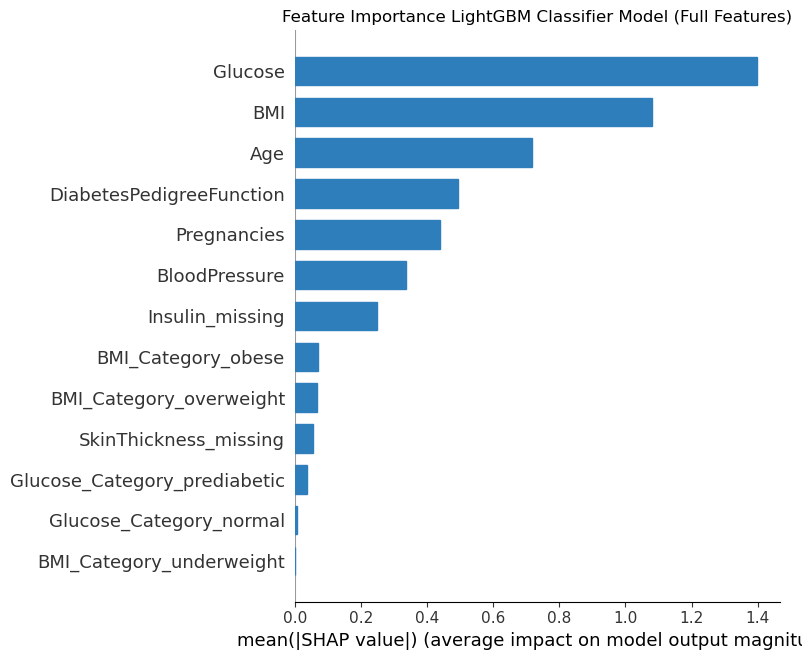

In [22]:
#!pip install lightgbm
from lightgbm import LGBMClassifier

# Initialize LightGBM and fit on processed train set
model = LGBMClassifier(scale_pos_weight=1.87, force_col_wise=True, random_state=0, verbose=-1).fit(X_train_processed, y_train)  # 65.1 / 34.9 = 1.87

# Predict
y_pred = model.predict(X_val_processed)

# Calculate classification report and confusion matrix
print(classification_report(y_val, y_pred))
print('Confusion Matrix:\n', confusion_matrix(y_val, y_pred))

# Check feature importance according to their SHAP values
# Explainer for LightGBM 
explainer = shap.Explainer(model, X_train_processed)
# Get SHAP values for the validation set
shap_values = explainer(X_val_processed, check_additivity=False)

# Visualize SHAP values for feature importance
plt.figure(figsize=(6,5))
shap.summary_plot(shap_values,
                  X_val_processed,
                  feature_names=feature_names_cleaned,
                  plot_type='bar',
                  show=False)
# Custom color for bars
for bar in plt.gca().patches:
    bar.set_color(blues_cmap(0.7))

plt.title('Feature Importance LightGBM Classifier Model (Full Features)')

plt.tight_layout()

### 5.b Selected features (according to their importance for the model)

Parameters: {'learning_rate': 0.02, 'max_depth': 7, 'min_child_samples': 50, 'n_estimators': 200, 'num_leaves': 15, 'reg_alpha': 0.1, 'reg_lambda': 1, 'scale_pos_weight': 2.5}, Cross-validated PR-AUC: 0.6734245340243262
{'ROC-AUC': 0.8485185185185186, 'PR-AUC': 0.7581291328718156, 'Precision (Weighted)': 0.7928841991341992, 'Recall (Weighted)': 0.7792207792207793, 'F1-Score (Weighted)': 0.7827658514545224, 'Specificity': 0.78, 'Accuracy': 0.7792207792207793}


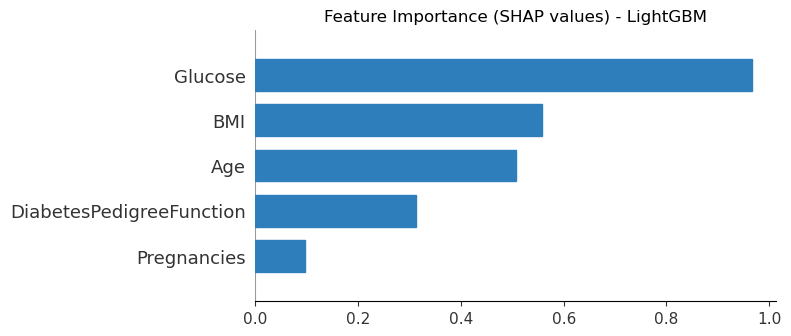

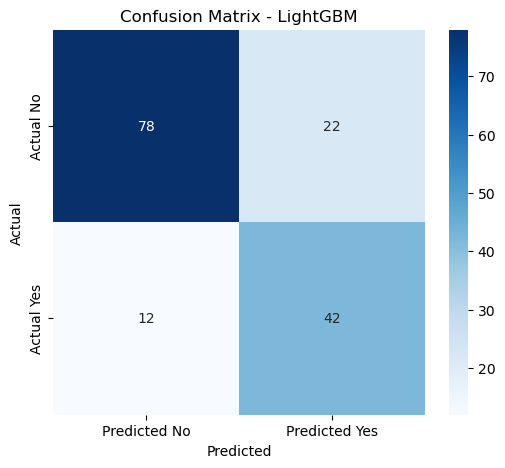

<Figure size 640x480 with 0 Axes>

In [23]:
# Get top 6 features indices frpm SHAP
top_features_idx = np.argsort(np.abs(shap_values.values).mean(axis=0))[-5:]

# Select top 8 features for train, validation and test sets
X_train_reduced = X_train_processed.iloc[:, top_features_idx]
X_val_reduced = X_val_processed.iloc[:, top_features_idx]
X_test_reduced = X_test_processed.iloc[:, top_features_idx]
X_train_val_reduced = X_train_val_processed.iloc[:, top_features_idx]

# Get cleaned top features
top_features = [col.split('__')[-1] for col in X_train_reduced.columns]

# Define the parameter grid
param_grid = {
    'n_estimators': [200],
    'learning_rate': [0.01, 0.02, 0.05],
    'max_depth': [7],
    'num_leaves': [15, 30],  
    'min_child_samples': [50],               # Reduce overfitting
    'reg_alpha': [0.1, 1, 2, 3],
    'reg_lambda': [0.05, 0.1, 1],
    'scale_pos_weight': [1.87, 2, 2.5]       # To handle class imbalance (approx 65/35 imbalance ratio)
}

# Initialize GridSearchCV
search = GridSearchCV(LGBMClassifier(force_col_wise=True, random_state=0, verbose=-1),
                      param_grid,
                      cv=5,
                      scoring='average_precision',
                      n_jobs=-1)
search.fit(X_train_reduced, y_train, feature_name=top_features)

# Best model
lgbm_classifier = search.best_estimator_

# Fit on combined train and validation sets
lgbm_classifier.fit(X_train_val_reduced, y_train_val)

# Best params
print(f'Parameters: {search.best_params_}, Cross-validated PR-AUC: {search.best_score_}')

# Calculate probabilities
y_prob_lgbm = lgbm_classifier.predict_proba(X_test_reduced)[:, 1]

# Evaluate model 
results = evaluate_model(lgbm_classifier, 'LightGBM', X_test_reduced, y_test, top_features, table)
print(results)

# Visualize SHAP feature importance and confusion matrix
plot_model_explanations(lgbm_classifier, 'LightGBM', X_train_val_reduced, X_test_reduced, y_test,
                        top_features, blues_cmap(0.7),'Blues')


# Comparison Analysis

+---------------------+---------+--------+----------------------+-------------------+---------------------+-------------+----------+----------+
|        Model        | ROC-AUC | PR-AUC | Precision (Weighted) | Recall (Weighted) | F1-Score (Weighted) | Specificity | Accuracy | Features |
+---------------------+---------+--------+----------------------+-------------------+---------------------+-------------+----------+----------+
| Logistic Regression |   0.88  |  0.81  |         0.79         |        0.79       |         0.79        |     0.8     |   0.79   |    4     |
|       XGBoost       |   0.86  |  0.79  |         0.79         |        0.79       |         0.79        |     0.81    |   0.79   |    4     |
|    Random Forest    |   0.84  |  0.77  |         0.79         |        0.78       |         0.78        |     0.8     |   0.78   |    5     |
|         SVM         |   0.87  |  0.78  |         0.79         |        0.77       |         0.77        |     0.75    |   0.77   |    

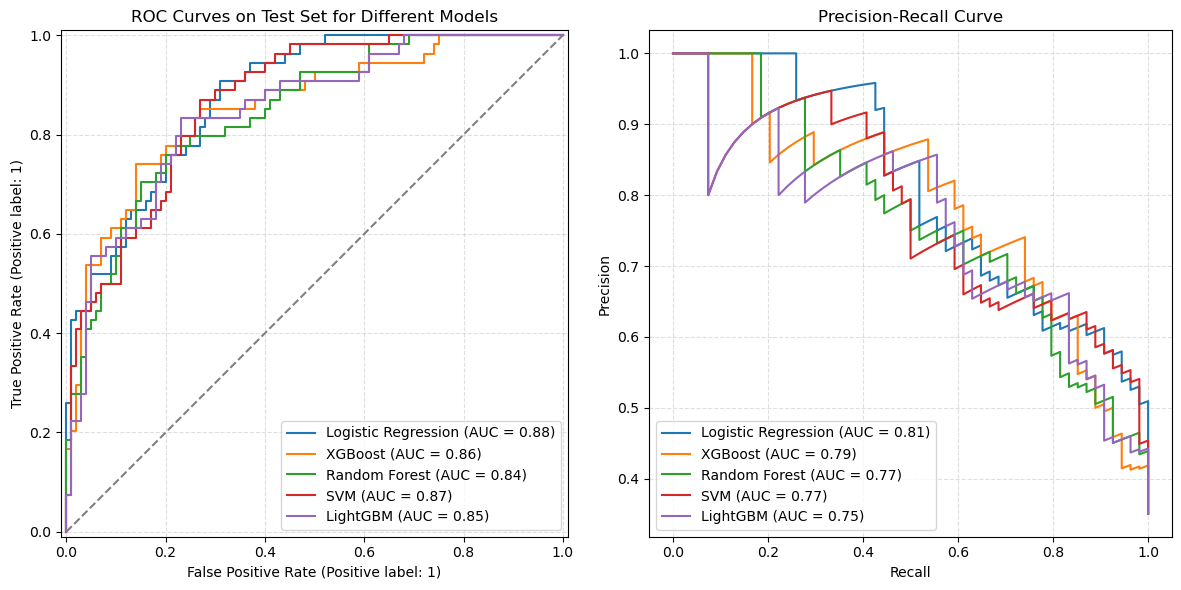

In [24]:
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, auc

# Table of comparison
print(table)

fig, ax = plt.subplots(1,2, figsize=(12,6))

# Plot each model
model_names = ['Logistic Regression', 'XGBoost', 'Random Forest', 'SVM', 'LightGBM']
probabilities = [y_prob_log_reg, y_prob_xgb, y_prob_rf, y_prob_svm, y_prob_lgbm]

for model, y_proba in zip(model_names, probabilities):
    RocCurveDisplay.from_predictions(y_test, y_proba, ax=ax[0], name=model)
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    auc_pr = auc(recall, precision)
    ax[1].plot(recall, precision, label=f'{model} (AUC = {auc_pr:.2f})')


ax[0].plot([0,1], [0,1], linestyle='--', color='gray', label='Random')
ax[0].set_title('ROC Curves on Test Set for Different Models')
ax[0].grid(linestyle='--', alpha=0.4)

ax[1].set(title='Precision-Recall Curve',
          xlabel='Recall',
          ylabel='Precision')
ax[1].grid(linestyle='--', alpha=0.4)

plt.legend()

plt.tight_layout()



In this small and imbalanced dataset (768 samples with a 65/35 class distribution), multiple models were evaluated for predicting diabetes, using key evaluation metrics including ROC-AUC, PR-AUC, sensitivity (recall), and specificity, all crucial in medical contexts.

Logistic Regression performed best overall, achieving the highest ROC-AUC (0.88) and PR-AUC (0.81), along with balanced precision, recall, F1-score, and specificity (0.80). This indicates it not only ranks positive cases well but also maintains a solid trade-off between catching actual diabetic cases (recall = 0.79) and avoiding false alarms (specificity = 0.80), which is vital in clinical decision-making.

Random Forest and XGBoost also showed strong performance (ROC-AUC of 0.84 and 0.86 respectively) with similar precision and recall, and slightly higher specificity (up to 0.81), making them reliable alternatives.

SVM and LightGBM underperformed slightly, particularly in terms of recall (0.77 and 0.75) and specificity (0.75 and 0.78). This suggests they missed more positive cases and also produced more false positives, which is less desirable in diabetes screening where both early detection and reducing unnecessary interventions are important. These results may reflect sensitivity to imbalance or overfitting due to the dataset’s small size. The ROC and PR curves reinforce these findings, with Logistic Regression maintaining the strongest curves throughout. Despite the small dataset, all models demonstrated reasonable performance. However, simpler models like Logistic Regression may generalize better, particularly when considering the balance between sensitivity and specificity essential in healthcare.

